In [0]:
!pip install pypianoroll
!pip install mido
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import mido
import pypianoroll
import matplotlib.pyplot as plt
from pypianoroll import Multitrack, Track
import pretty_midi as pmidi
import os
import numpy as np
import time

from google.colab import drive 
drive.mount('/content/drive', force_remount= True)


drive_path    = 'drive/My Drive/Capstone - ECE496/'
data_in_path  = 'midi/'
output_path ='out_midi/'

midi_dir = drive_path + data_in_path
out_dir = drive_path + output_path

In [1]:
#TODO extract and store tempo information?
# ValueError: Cannot get beat timings to quantize pianoroll. on iteration ~3000
#issue in either pypianoroll.parse_midi or pypianoroll.write
'''
list entire directory
get unique file #s ->xxx.xxx.midi
load pairs of files into lists of tuples
'''

max_counter=3
counter=0

#contains an array of tuples(input, target)
tupleArr=[]

#contains a 2 element tuple, converted into tuple type later
tuple_list=[]

dir_path = "drive/My Drive/Capstone - ECE496/single_note_random_split"
dir_files = os.listdir(dir_path)
dir_files.sort()
current_song=""

for midi_file_num in dir_files:
  '''
  #extract tempo
  song_tempo = 0
  test_file = mido.MidiFile(dir_path +"/" + midi_file_num)
  for msg in test_file:
    if msg.is_meta:
        split = str(msg).split()
        if 'set_tempo' in split:
            song_tempo = int(mido.tempo2bpm(int(split[3].split('=')[1]))) #mido uses tempo in ms/beat but pypianoroll uses beat/min as tempo
            break
  '''
  '''
  if bad_list:
    if midi_file_num in bad_list:
        pproll = pypianoroll.parse(dir_path + "/" + midi_file_num)
        print(midi_file_num, len(pproll.tracks[0].pianoroll))
  '''
  #set flag to false at beginning of each iteration
  new_song = False

  #checks if we are in a new song or current song
  if(current_song != midi_file_num.split(".")[0]):
    new_song = True
    current_song = midi_file_num.split(".")[0]

  #gets the current song interval part  
  current_part = midi_file_num.split(".")[1]

  #if in a new song, reset variables
  if new_song:
    index=0
    tuple_list=[]


  
  #add element to tuple
  pproll = None
  pproll = pypianoroll.parse(dir_path + "/" + midi_file_num)
  pproll.name = midi_file_num
  #to indicate timesteps with no note on
  for i in range(len(pproll.tracks)): #iterate over tracks
    for j in range(len(pproll.tracks[i].pianoroll)): #iterate over timesteps
      for k in range(len(pproll.tracks[i].pianoroll[j])): #iterate over notes
        if pproll.tracks[i].pianoroll[j][k] != 0:
          pproll.tracks[i].pianoroll[j][k] = 1
      if 1 not in pproll.tracks[i].pianoroll[j]:
          pproll.tracks[i].pianoroll[j][0] = 1 #TODO make this less sketchy, setting index 0 = 1 to represent no notes on

  tuple_list.append(pproll)

  #if tuple(input, target) complete, add to array of tuples, reset vars
  if(index != 1):
    index=index+1
  elif(index ==1):

    #tuple has both input and target now
    t = tuple(tuple_list)
    #print(t)
    tupleArr.append(t)

    #reset and add initial element to tuple
    tuple_list = []
    pproll = None
    pproll = pypianoroll.parse(dir_path + "/" + midi_file_num)
    pproll.name = midi_file_num
    
    #to indicate timesteps with no note on
    for i in range(len(pproll.tracks)): #iterate over tracks
      for j in range(len(pproll.tracks[i].pianoroll)): #iterate over timesteps
        for k in range(len(pproll.tracks[i].pianoroll[j])): #iterate over notes
            if pproll.tracks[i].pianoroll[j][k] != 0:
              pproll.tracks[i].pianoroll[j][k] = 1
        if 1 not in pproll.tracks[i].pianoroll[j]:
            pproll.tracks[i].pianoroll[j][0] = 1 #TODO make this less sketchy, setting index 0 = 1 to represent no notes on

    tuple_list.append(pproll)

  if(counter == max_counter):
    break
  if (counter%100 == 0):
    print(counter)
  counter = counter+1
  
train_data=tupleArr
data_pairs= []
tuple_list=[]
time_factor = 10
for pair in train_data:
  assert(pair[0].tracks[0].pianoroll.shape[0]==pair[1].tracks[0].pianoroll.shape[0])
  time_steps= pair[0].tracks[0].pianoroll.shape[0]
  input_matrix=np.empty([time_steps,25])
  target_matrix=np.empty([time_steps,25])
  for time_step in range(time_steps):
    input_matrix[time_step][0]=((pair[0].tracks[0].pianoroll)[time_step][0])
    input_matrix[time_step][1:25]=((pair[0].tracks[0].pianoroll)[time_step][48:72])
    target_matrix[time_step][0]=((pair[1].tracks[0].pianoroll)[time_step][0])
    target_matrix[time_step][1:25]=((pair[1].tracks[0].pianoroll)[time_step][48:72])
	
  reduced_time = int(time_steps/time_factor)
  input_matrix = input_matrix[time_steps-reduced_time : ]
  print(len(input_matrix))
  print(torch.argmax(torch.tensor(input_matrix), dim = 1))
  target_matrix = target_matrix[  : reduced_time]
  print(len(target_matrix))
  print(torch.argmax(torch.tensor(target_matrix), dim = 1))
  tuple_list.append(input_matrix)
  tuple_list.append(target_matrix)
  data_pairs.append(tuple(tuple_list))
#print(tupleArr)

NameError: ignored

In [0]:
#debugging length of pianoroll mismatches between melody and extension
print(len(tupleArr))
bad_list = []
for i in range(len(tupleArr)):
    t = tupleArr[i]
    mel = t[0].tracks[0].pianoroll
    ext = t[1].tracks[0].pianoroll
    if (len(mel) != len(ext)):
        #print(i, len(mel), len(ext))
        #print(t[0].name, t[1].name)
        #print(len(mel), len(ext))
        bad_list.append(t[0].name)
        tupleArr.remove(tupleArr[i])
print(bad_list)
print(len(tupleArr), len(bad_list))

3
[]
3 0


In [0]:
#debugging setting timestep of 0s to 1 
print(len(tupleArr))
tupleArr = tupleArr[0:10]
for i in range(len(tupleArr)):
    print("index", i)
    t = tupleArr[i][0].tracks[0].pianoroll
    for j in t:
        for k in range(len(j)):
            if j[k] == 1 and k > 100 :
                print (k)
for t in tupleArr:
    tens = torch.tensor(t[0].tracks[0].pianoroll)
    print(tens.shape)
    print(tens)
    amax = torch.argmax(tens, dim = 1)
    print(amax.shape)
    print(amax)
    break
#argmax is returning 127 when it doesnt find a max, but it should always be finding one (oops i missed a couple lines of code in the tupleArr logic)

In [0]:
class SingleNoteRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size = 128, n_layers = 1):
        super(SingleNoteRNN, self).__init__()
        self.vocab_size = vocab_size
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, data, hidden = None):
        output, hidden = self.rnn(data, hidden) # get the next output and hidden state
        output = self.decoder(output)          # predict distribution over next tokens
        output = self.ReLU(output)
        return output, hidden


In [0]:
def accuracy(model_output, truth):
    #if (len(model_output) != len(truth)):
    #    assert("error: size mismatch: model_output vs truth")
    #else:
    print(model_output.shape, truth.shape)
    preds = torch.argmax(model_output, dim = 2)
    correct = int((torch.eq(pred, truth)).sum())
    #print(preds)
    #print(truth)
    return 

def train_SNRNN(model, train_data, val_data = None, epochs = 10, batch_size = 64, learning_rate = 1e-3):
    train_loss_list, val_loss_list, train_acc_list, val_acc_list = [],[],[],[]
    
    criterion = nn.CrossEntropyLoss() #.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
    
    for epoch in range(0, epochs):
        epoch_time = time.time()
        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0
        for pair in train_data:
          input =  torch.tensor(pair[0].tracks[0].pianoroll).unsqueeze(0).float()
          target = torch.tensor(pair[1].tracks[0].pianoroll).unsqueeze(0).float()
          target = torch.argmax(target, dim=2)
          
          optimizer.zero_grad()
          output, hidden = model(input)
          loss = criterion(output.reshape(1, input.shape[2], -1), target)
          loss.backward()
          optimizer.step()

          #calculate accuracy
          pred = torch.argmax(output, dim = 2)
          print(pred, target)
          time.sleep(2)
          for i in range(len(pred.reshape(-1))):
              if int(pred.reshape(-1)[i]) == int( target.reshape(-1)[i]):
                  epoch_correct +=1
          #epoch_correct += int((torch.eq(pred.reshape(-1), target.reshape(-1))).sum())
          epoch_total += pred.shape[1]

          epoch_loss += float(loss)
          
        #print(epoch_correct, epoch_total)
        epoch_accuracy = (epoch_correct/epoch_total)*100
        print(epoch, int(time.time()-epoch_time), "s :loss:", epoch_loss, "accuracy", epoch_accuracy)
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_loss)


    
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list
    
model = SingleNoteRNN( 256)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_SNRNN(model, tupleArr, epochs = 500, learning_rate = 1e-2)

SyntaxError: ignored

In [0]:
#testing concatenation
def accuracy(model_output, truth):
    #if (len(model_output) != len(truth)):
    #    assert("error: size mismatch: model_output vs truth")
    #else:
    print(model_output.shape, truth.shape)
    preds = torch.argmax(model_output, dim = 2)
    correct = int((torch.eq(pred, truth)).sum())
    #print(preds)
    #print(truth)
    return 

def train_SNRNN(model, train_data, val_data = None, epochs = 10, batch_size = 64, learning_rate = 1e-3):
    train_loss_list, val_loss_list, train_acc_list, val_acc_list = [],[],[],[]
    
    criterion = nn.CrossEntropyLoss() #.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
    
    for epoch in range(0, epochs):
        epoch_time = time.time()
        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0
        input_matrix=np.empty([600,25])
        target_matrix=np.empty([600,25])
        for pair in train_data:

          for cat in range(0,pair[0].tracks[0].pianoroll.shape[0]):
            input_matrix[cat][0]=((pair[0].tracks[0].pianoroll)[cat][0])
            input_matrix[cat][1:25]=((pair[0].tracks[0].pianoroll)[cat][47:71])
            target_matrix[cat][0]=((pair[1].tracks[0].pianoroll)[cat][0])
            target_matrix[cat][1:25]=((pair[1].tracks[0].pianoroll)[cat][47:71])
          
          
          input =  torch.tensor(input_matrix).unsqueeze(0).float()         
          target_one_hot = torch.tensor(target_matrix).unsqueeze(0).float()
          target = torch.argmax(target_one_hot, dim=2)

          optimizer.zero_grad()
          output1, hidden1 = model(input)
          #print(output1.reshape(1, input.shape[2], -1).shape, target.shape)
          output, hidden2 = model(target_one_hot, hidden1)
          loss = criterion(output.reshape(1, input.shape[2], -1), target)
          loss.backward()
          optimizer.step()

          #calculate accuracy
          pred = torch.argmax(output, dim = 2)
          #print(pred, target)
          #time.sleep(2)
          for i in range(len(pred.reshape(-1))):
              if int(pred.reshape(-1)[i]) == int( target.reshape(-1)[i]):
                  epoch_correct +=1
          #epoch_correct += int((torch.eq(pred.reshape(-1), target.reshape(-1))).sum())
          epoch_total += pred.shape[1]

          epoch_loss += float(loss)

        #print(epoch_correct, epoch_total)
        epoch_accuracy = (epoch_correct/epoch_total)*100
        print(epoch, int(time.time()-epoch_time), "s :loss:", epoch_loss, "accuracy", epoch_accuracy)
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_loss)


    
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list
    
model = SingleNoteRNN( 256, vocab_size = 25)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_SNRNN(model, tupleArr, epochs = 100, learning_rate = 0.5)

0 3 s :loss: 16.063558101654053 accuracy 7.277777777777778
1 2 s :loss: 13.69808316230774 accuracy 1.8333333333333333
2 3 s :loss: 14.763806819915771 accuracy 1.8333333333333333
3 3 s :loss: 21.548787117004395 accuracy 1.8333333333333333
4 3 s :loss: 12.230830907821655 accuracy 1.8333333333333333


KeyboardInterrupt: ignored

NameError: ignored

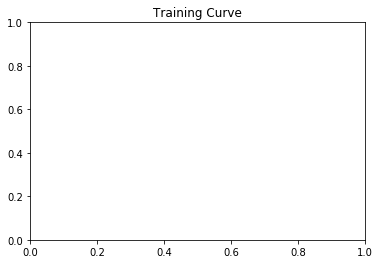

In [0]:
# plotting
plt.title("Training Curve")
plt.plot(train_loss_list, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.title("Training Curve")
plt.plot(epochs, train_acc_list, label="Train")
plt.plot(epochs, val_acc_list, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

